# Tutorial HowToAdaptiveOptics

This report provides a tutorial to use the code develloped to compute the PSIM for the ELT SCAO systems. 
The code is object-oriented and its architecture is quite inspired from the ([OOMAO simulator](https://github.com/cmcorreia/LAM-Public/tree/master/_libOomao)).



## Modules required
The code is written in Python 3 and requires the following modules

* **numba**          => required in aotools
* **joblib**         => paralleling computing
* **scikit-image**   => 2D interpolations
* **numexpr**        => memory optimized simple operations
* **astropy**        => handling of fits files

To be able to use the code you need to install the listed modules using the following command lines in a terminal:

*pip install aotools*

*pip install numba*

*pip install joblib*

*pip install scikit-image*

*pip install numexpr*

*pip install astropy*


### Import Modules

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct 21 10:51:32 2020

@author: cheritie
"""
# commom modules
import matplotlib.pyplot as plt
import numpy             as np 
import time

# adding AO_Module to the path
import __load__psim
__load__psim.load_psim()

# loading AO modules
from AO_modules.Atmosphere       import Atmosphere
from AO_modules.Pyramid          import Pyramid
from AO_modules.DeformableMirror import DeformableMirror
from AO_modules.MisRegistration  import MisRegistration
from AO_modules.Telescope        import Telescope
from AO_modules.Source           import Source

# calibration modules 
from AO_modules.calibration.compute_KL_modal_basis import compute_M2C
from AO_modules.calibration.ao_calibration import ao_calibration

# display modules
from AO_modules.tools.displayTools           import displayMap


Looking for AO_Modules...
['../AO_modules']
AO_Modules found! Loading the main modules:


### Read Parameter File

In [3]:
#import parameter file (dictionnary)

from parameterFile_VLT_I_Band import initializeParameterFile

param = initializeParameterFile()
# the list of the keys contained in the dictionnary can be printed using the following lines
# for key, value in param.items() :
#     print (key, value)

Reading/Writting calibration data from /Disk3/cheritier/psim/data_calibration/
Writting output data in /diskb/cheritier/psim/data_cl
Creation of the directory /diskb/cheritier/psim/data_cl failed:
Directory already exists!


## Telescope Object

In [4]:
# create the Telescope object
tel = Telescope(resolution          = param['resolution'],\
                diameter            = param['diameter'],\
                samplingTime        = param['samplingTime'],\
                centralObstruction  = param['centralObstruction'])

NGS flux updated!
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% SOURCE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Wavelength 	0.55 	 [microns]
Optical Band 	V
Magnitude 	-0.0
Flux 		8967391304.0	 [photons/m2/s]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% SOURCE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Wavelength 	0.55 	 [microns]
Optical Band 	V
Magnitude 	-0.0
Flux 		8967391304.0	 [photons/m2/s]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% TELESCOPE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Diameter 			8 	 [m]
Resolution 			80 	 [pix]
Pixel Size 			0.1	 [m]
Surface 			50.0	 [m2]
Central Obstruction 		0	 [% of diameter]
Number of pixel in the pupil 	5024 	 [pix]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


The mai informations contained in the telescope objects are the following: 
* tel. pupil : the pupil of the telescope as a 2D mask

* tel.src    : the source object attached to the telescope that contains the informations related to the wavelength, flux and phase. The default wavelength is the V band with a magnitude 0.

* tel.OPD    : the telescope OPD corresponding to the tel.src.phase 

All the properties of an object can be displayed using the .show() method: 

In [5]:
tel.show()

telescope:
          D: 8
          OPD: (80, 80)
          centralObstruction: 0
          fov: 0
          index_pixel_petals: None
          isPaired: False
          isPetalFree: False
          pixelArea: 5024
          pixelSize: 0.1
          pupil: (80, 80)
          pupilLogical: (1, 5024)
          pupilReflectivity: (80, 80)
          resolution: 80
          samplingTime: 0.001
          src: source object
          tag: telescope


We can show the 2D map corresponding to the pupil or to the OPD:

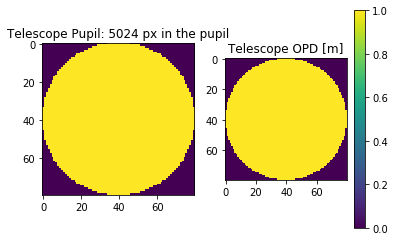

In [6]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(tel.pupil.T)
plt.title('Telescope Pupil: %.0f px in the pupil' %tel.pixelArea)
plt.subplot(1,2,2)
plt.imshow(tel.OPD.T)
plt.title('Telescope OPD [m]')
plt.colorbar()

And we can display the property of the child class tel.src that correspond to the default source object attached to the telescope:

In [7]:
tel.src.show()

source:
          bandwidth: 9e-08
          magnitude: -0.0
          nPhoton: 8967391304.347826
          optBand: V
          phase: (80, 80)
          tag: source
          wavelength: 5.5e-07
          zeroPoint: 8967391304.347826


## Source Object
The Source object allows to access the properties related to the flux and wavelength of the object. We consider only on-axis objects as a start. 

In [8]:
ngs=Source(optBand   = param['opticalBand'],\
           magnitude = param['magnitude'])
print('NGS Object built!')

NGS flux updated!
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% SOURCE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Wavelength 	0.79 	 [microns]
Optical Band 	I
Magnitude 	8.0
Flux 		4629307.0	 [photons/m2/s]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% SOURCE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Wavelength 	0.79 	 [microns]
Optical Band 	I
Magnitude 	8.0
Flux 		4629307.0	 [photons/m2/s]
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
NGS Object built!


The NGS object has to be attached to a telescope object using the ***** operator. 

This operation sets the telescope property tel.src to the ngs object considered. 

In [9]:
ngs*tel

The ngs object is now attached to the telescope. This means that the tel.src object now has a **phase** and a **fluxMap** property.

If we display the properties of ngs and tel.src, they are the same: 

In [10]:
# properties of ngs
ngs.show()
# properties of tel.src
tel.src.show()

source:
          bandwidth: 1.5e-07
          fluxMap: (80, 80)
          magnitude: 8.0
          nPhoton: 4629306.603523155
          optBand: I
          phase: (80, 80)
          tag: source
          var: 8.673617379884035e-19
          wavelength: 7.9e-07
          zeroPoint: 7336956521.73913
source:
          bandwidth: 1.5e-07
          fluxMap: (80, 80)
          magnitude: 8.0
          nPhoton: 4629306.603523155
          optBand: I
          phase: (80, 80)
          tag: source
          var: 8.673617379884035e-19
          wavelength: 7.9e-07
          zeroPoint: 7336956521.73913


We can compute and display the PSF corresponding to the telescope OPD and Source object attached to the telescope. 

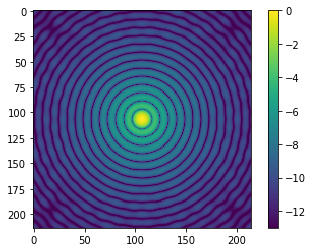

In [13]:

zeroPaddingFactor = 8

tel.computePSF(zeroPaddingFactor = zeroPaddingFactor)

PSF_normalized = tel.PSF/tel.PSF.max()

nPix = zeroPaddingFactor*tel.resolution//3

plt.figure()
plt.imshow(np.log(np.abs(PSF_normalized[nPix:-nPix,nPix:-nPix])))
plt.clim([-13,0])
plt.colorbar()



## Atmosphere Object
The atmosphere object is created mainly from the telescope properties (diameter, pupil, samplingTime)and the *r0* and *L0* parameters. It is possible to generate multi-layers, each one is a child-class of the atmosphere object with its own set of parameters (windSpeed, Cn^2,windDirection, altitude). 


In [14]:
atm=Atmosphere(telescope     = tel,\
               r0            = param['r0'],\
               L0            = param['L0'],\
               windSpeed     = param['windSpeed'],\
               fractionalR0  = param['fractionnalR0'],\
               windDirection = param['windDirection'],\
               altitude      = param['altitude'])

print('Atmosphere Object built!')

Atmosphere Object built!


The atmosphere object has to be initialized using:

In [15]:
# initialize atmosphere
atm.initializeAtmosphere(tel)
print('Done!')

Creation of layer1/5 ...
-> Computing the initial phase screen...
initial phase screen : 0.023934602737426758 s
ZZt.. : 0.7004520893096924 s
ZXt.. : 0.3715839385986328 s
XXt.. : 0.2279503345489502 s
Done!
Creation of layer2/5 ...
-> Computing the initial phase screen...
initial phase screen : 0.036902666091918945 s
ZZt.. : 1.2596936225891113 s
ZXt.. : 0.6154317855834961 s
XXt.. : 0.26628828048706055 s
Done!
Creation of layer3/5 ...
-> Computing the initial phase screen...
initial phase screen : 0.031950950622558594 s
ZZt.. : 0.9521989822387695 s
ZXt.. : 0.4208860397338867 s
XXt.. : 0.20944452285766602 s
Done!
Creation of layer4/5 ...
-> Computing the initial phase screen...
initial phase screen : 0.026932239532470703 s
ZZt.. : 0.998450517654419 s
ZXt.. : 0.5060114860534668 s
XXt.. : 0.22093653678894043 s
Done!
Creation of layer5/5 ...
-> Computing the initial phase screen...
initial phase screen : 0.028923749923706055 s
ZZt.. : 0.9069092273712158 s
ZXt.. : 0.4238872528076172 s
XXt.. : 

Similarly to the Source object, the atmosphere object can be paired to the telescope **+**. 

In that case, if the atmosphere OPD is updated, the telescope OPD is automatically updated.

In [16]:
tel+atm
print(tel.isPaired)

Telescope and Atmosphere combined!
True


We can display the properties of the telescope object:

Text(0.5, 1.0, 'NGS Phase [rad]')

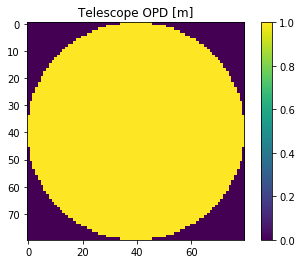

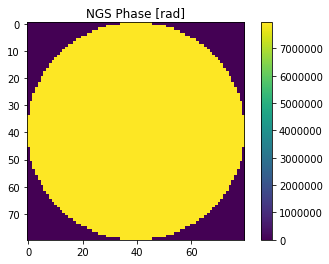

In [19]:
plt.figure()
plt.imshow(tel.OPD.T)
plt.title('Telescope OPD [m]')
plt.colorbar()

plt.figure()
plt.imshow(tel.src.phase.T)
plt.colorbar()
plt.title('NGS Phase [rad]')

The atmosphere and the telescope can be separated using the **-** operator. This brings back the system to a diffraction limited case with a flat OPD.

In [18]:
tel-atm
print(tel.isPaired)

Telescope and Atmosphere separated!
False


## Deformable Mirror Object
The deformable mirror is mainly characterized with its influence functions. They can be user-defined and loaded in the model but the default case is a cartesian DM with gaussian influence functions and normalized to 1. 
The DM is always defined in the pupil plane. 


In [20]:
dm=DeformableMirror(telescope    = tel,\
                    nSubap       = param['nSubaperture'],\
                    mechCoupling = param['mechanicalCoupling'])
print('Done!')

No coordinates loaded.. taking the cartesian geometry as a default
Generating a Deformable Mirror: 
Computing the 2D zonal modes...
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% DEFORMABLE MIRROR %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Controlled Actuators 	 357
M4 influence functions 	 No
Pixel Size 		0.1 	 [m]
Pitch 			 0.4 	 [m]
Mechanical Coupling 	 0.45 	 [m]
Rotation: 0 deg -- shift X: 0 m -- shift Y: 0 m -- Anamorphosis Angle: 0 deg -- Radial Scaling: 0 -- Tangential Scaling: 0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Done!


We can display the cube of the influence functions to display the position of the actuators.


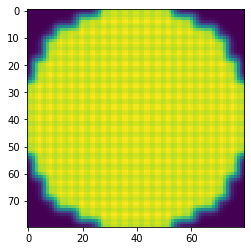

In [23]:
cube_IF = np.reshape(np.sum(dm.modes**3, axis =1),[tel.resolution,tel.resolution])
plt.figure()
plt.imshow(cube_IF.T)

### Light propagation
The light can be propagate through the DM using the ***** operator. 

To update the DM surface, the property **dm.coefs** must be updated to set the new values of the DM coefficients.

Typically, using a random command vector, we can propagate the light through the DM (light is reflected hence the sign change and the factor 2 in OPD):

Telescope and Atmosphere separated!


Text(0.5, 1.0, 'Atmosphere OPD [m]')

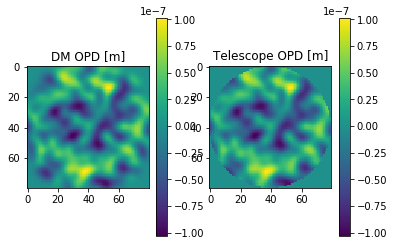

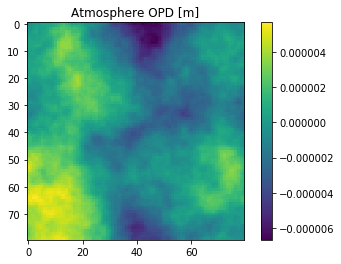

In [27]:
tel-atm

dm.coefs = (np.random.rand(dm.nValidAct)-0.5)*100e-9
tel*dm
plt.figure()
plt.subplot(121)
plt.imshow(dm.OPD)
plt.title('DM OPD [m]')
plt.colorbar()
plt.subplot(122)
plt.imshow(tel.OPD)
plt.colorbar()
plt.title('Telescope OPD [m]')
plt.figure()
plt.imshow(atm.OPD_no_pupil)
plt.colorbar()
plt.title('Atmosphere OPD [m]')


### Mis-registrations
The DM/WFS mis-registrations are applied directly in the DM space, applying the transformations on the DM influence functions. 

First we create a **MisRegistration Object** that is initialized to 0. 

We can then update the values of the mis-registrations and input it to the DM model:

No coordinates loaded.. taking the cartesian geometry as a default
Generating a Deformable Mirror: 
Computing the 2D zonal modes...
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% DEFORMABLE MIRROR %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Controlled Actuators 	 357
M4 influence functions 	 No
Pixel Size 		0.1 	 [m]
Pitch 			 0.4 	 [m]
Mechanical Coupling 	 0.45 	 [m]
Rotation: 3 deg -- shift X: 0.12 m -- shift Y: 0.1 m -- Anamorphosis Angle: 0 deg -- Radial Scaling: 0 -- Tangential Scaling: 0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Done!


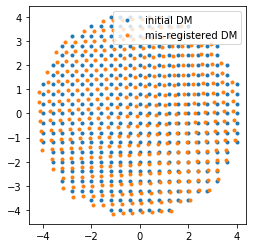

In [25]:
misReg = MisRegistration()
misReg.rotationAngle = 3
misReg.shiftX        = 0.3*param['diameter']/param['nSubaperture']
misReg.shiftY        = 0.25*param['diameter']/param['nSubaperture']

dm_misReg = DeformableMirror(telescope    = tel,\
                    nSubap       = param['nSubaperture'],\
                    mechCoupling = param['mechanicalCoupling'],\
                    misReg       = misReg)
print('Done!')

plt.figure()
plt.plot(dm.coordinates[:,0],dm.coordinates[:,1],'.')
plt.plot(dm_misReg.coordinates[:,0],dm_misReg.coordinates[:,1],'.')
plt.axis('square')
plt.legend(['initial DM','mis-registered DM'])


## Pyramid Object
The pyramid object consists mainly in defining the PWFS mask to apply the filtering of the electro-magnetic field. 
Many parameters can allow to tune the pyramid model:
* Centering of the mask and of the FFT on 1 or 4 pixels
* Modulation radius in λ/D. By default the number of modulation points ensures to have one point every λ/D on the circular trajectory but this sampling can be modified by the user. The number of modulation points is a multiple of 4 to ensure that each quadrant has the same number of modulation points.
* The modulation value for the calibration and selection of the valid pixels
* PWFS pupils separation, either for a perfect pyramid with a single value or for an imperfect pyramid with 8 values (shift X and Y for each PWFS pupil) . 
* The type of post-processing of the PWFS signals (slopes-maps, full-frame,etc). To be independent from this choice, the pyramid signals are named “wfs.pyramidSignal_2D” for either the Slopes-Maps or the camera frame and “wfs.pyramidSignal” for the signal reduced to the valid pixels considered.
* The intensity threshold to select the valid pixel 

Some optional features can be user-defined:
* Zero-padding value
* Number of  pixel on the edge of the Pyramid pupils
* The units of the WFS signals can be calibrated using a ramp of Tip/Tilt


In addition, the Pyramid object has a Detector object as a child-class that provides the pyramid signals. It can be access through **wfs.cam**

In [28]:
# make sure tel and atm are separated to initialize the PWFS
tel-atm

# create the Pyramid Object
wfs = Pyramid(nSubap                = param['nSubaperture'],\
              telescope             = tel,\
              modulation            = param['modulation'],\
              lightRatio            = param['lightThreshold'],\
              pupilSeparationRatio  = param['pupilSeparationRatio'],\
              calibModulation       = param['calibrationModulation'],\
              psfCentering          = param['psfCentering'],\
              edgePixel             = param['edgePixel'],\
              unitCalibration       = param['unitCalibration'],\
              extraModulationFactor = param['extraModulationFactor'],\
              postProcessing        = param['postProcessing'])


Telescope and Atmosphere separated!
Pyramid Mask initialization...
Done!
Selection of the valid pixels...
The valid pixel are selected on flux considerations
Done!
Acquisition of the reference slopes and units calibration...
WFS calibrated!
Done!
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% PYRAMID WFS %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Pupils Diameter 	20 	 [pixels]
Pupils Separation 	3.999999999999999 	 [pixels]
Pixel Size 		0.4	 [m]
TT Modulation 		3 	 [lamda/D]
PSF Core Sampling 	1 	 [pixel(s)]
Signal Post-Processing 	slopesMaps
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


The light can be propagated to the WFS through the different objects with using the ***** operator:

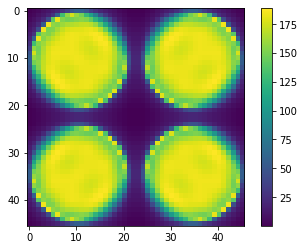

In [29]:
tel*wfs

plt.figure()
plt.imshow(wfs.cam.frame)
plt.colorbar()



We can display the PWFS signals that corresponds to a random actuation of the DM:

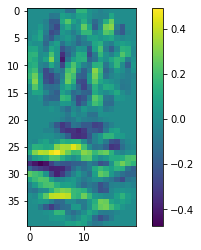

In [30]:
dm.coefs = (np.random.rand(dm.nValidAct)-0.5)*100e-9
tel*dm*wfs

plt.figure()
plt.imshow(wfs.pyramidSignal_2D)
plt.colorbar()

## Modal Basis
In this tutorial, we compute the mode-to-commands matrix (M2C) using the codes provided by C.Verinaud. It corresponds to a KL modal basis orthogonolized in the DM space.

In [31]:
# compute the modal basis
foldername_M2C  = None  # name of the folder to save the M2C matrix, if None a default name is used 
filename_M2C    = None  # name of the filename, if None a default name is used 


M2C_KL = compute_M2C(telescope            = tel,\
                                 atmosphere         = atm,\
                                 deformableMirror   = dm,\
                                 param              = param,\
                                 nameFolder         = None,\
                                 nameFile           = None,\
                                 remove_piston      = True,\
                                 HHtName            = None,\
                                 baseName           = None ,\
                                 mem_available      = 8.1e9,\
                                 minimF             = False,\
                                 nmo                = 300,\
                                 ortho_spm          = True,\
                                 SZ                 = np.int(2*tel.OPD.shape[0]),\
                                 nZer               = 3,\
                                 NDIVL              = 1)


Creation of the directory /Disk3/cheritier/psim/data_calibration/ failed:
Directory already exists!
COMPUTING TEL*DM...
 
PREPARING IF_2D...
 
Computing Specific Modes ...
 
COMPUTING VON KARMAN 2D PSD...
 
COMPUTING COV MAT HHt...
 
TIME ELAPSED: 3 sec. COMPLETED: 100 %
SERIALIZING IFs...
 
SERIALIZING Specific Modes...                    
 
COMPUTING IFs CROSS PRODUCT...
 
NMAX =  300
RMS opd error = [[1.16127888e-08 1.75899251e-08 1.75899251e-08]]
RMS Positions = [[7.26577110e-08 3.29310827e-07 3.29310827e-07]]
MAX Positions = [[4.52339280e-07 8.84512596e-07 8.84512596e-07]]
CHECKING ORTHONORMALITY OF SPECIFIC MODES...
 
Orthonormality error for SpM =  3.3306690738754696e-16
BUILDING SEED BASIS ...
 
Orthonormality error for 304 modes of the Seed Basis =  2.2426505097428162e-14
KL WITH DOUBLE DIAGONALISATION: COVARIANCE ERROR =  5.993844598436698e-14
Orthonormality error for 300 modes of the KL Basis =  2.020605904817785e-14
Piston removed from the modal basis!


## Interaction Matrix
The interaction matrix can be computed using the M2C matrix and the function interactionMatrix.
The output is stored as a class that contains all the informations about the inversion (SVD) such as eigenValues, reconstructor, etc. 

It is possible to add a **phaseOffset** to the interactionMatrix measurement. 

In [ ]:
#%% to manually measure the interaction matrix
#
## amplitude of the modes in m
#stroke=1e-9
## Modal Interaction Matrix 
#M2C = M2C[:,:param['nModes']]
#from AO_modules.calibration.InteractionMatrix import interactionMatrix
#
#calib = interactionMatrix(ngs            = ngs,\
#                             atm            = atm,\
#                             tel            = tel,\
#                             dm             = dm,\
#                             wfs            = wfs,\
#                             M2C            = M2C,\
#                             stroke         = stroke,\
#                             phaseOffset    = 0,\
#                             nMeasurements  = 100,\
#                             noise          = False)
#
#plt.figure()
#plt.plot(np.std(calib.D,axis=0))
#plt.xlabel('Mode Number')
#plt.ylabel('WFS slopes STD')
#plt.ylabel('Optical Gain')



In [32]:
param['nModes'] =300

ao_calib =  ao_calibration(param            = param,\
                           ngs              = ngs,\
                           tel              = tel,\
                           atm              = atm,\
                           dm               = dm,\
                           wfs              = wfs,\
                           nameFolderIntMat = None,\
                           nameIntMat       = None,\
                           nameFolderBasis  = None,\
                           nameBasis        = None,\
                           nMeasurements    = 100)


Creation of the directory /Disk3/cheritier/psim/data_calibration/ failed:
Directory already exists!
Loading the KL Modal Basis from: /Disk3/cheritier/psim/data_calibration/M2C_80_res
Computing the pseudo-inverse of the modal basis...
Diagonality criteria: 1.7785772854495008e-13 -- using the fast computation
Creation of the directory /Disk3/cheritier/psim/data_calibration/VLT_I_band_20x20/ failed:
Directory already exists!
Loading Interaction matrix zonal_interaction_matrix_80_res_3_mod_slopesMaps_psfCentering_False...
Done!
No Modal Gains found. All gains set to 1


## Display Modal Basis


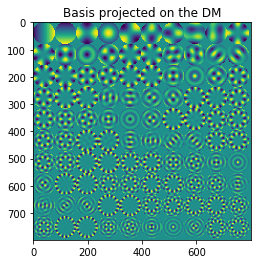

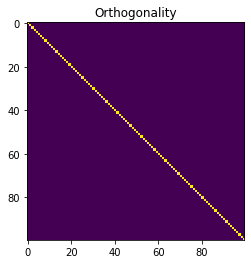

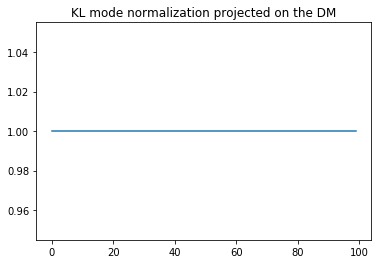

In [33]:

# project the mode on the DM
dm.coefs = ao_calib.M2C[:,:100]

tel*dm
#
# show the modes projected on the dm, cropped by the pupil and normalized by their maximum value
displayMap(tel.OPD,norma=True)
plt.title('Basis projected on the DM')

KL_dm = np.reshape(tel.OPD,[tel.resolution**2,tel.OPD.shape[2]])

covMat = (KL_dm.T @ KL_dm) / tel.resolution**2

plt.figure()
plt.imshow(covMat)
plt.title('Orthogonality')
plt.show()

plt.figure()
plt.plot(np.round(np.std(np.squeeze(KL_dm[tel.pupilLogical,:]),axis = 0),5))
plt.title('KL mode normalization projected on the DM')
plt.show()


## Closed Loop
Here is a code to do a closed-loop simulation using the PSIM code:

Telescope and Atmosphere combined!


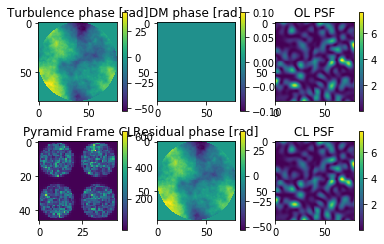

Elapsed time: 0.2678806781768799 s
Loop0/100 Turbulence: 2220.0512529022317 -- Residual:2220.0512529022317

Elapsed time: 0.16156816482543945 s
Loop1/100 Turbulence: 2219.395196782345 -- Residual:2219.395196782345

Elapsed time: 0.27361202239990234 s
Loop2/100 Turbulence: 2218.3590306278384 -- Residual:2185.065066873524

Elapsed time: 0.2837657928466797 s
Loop3/100 Turbulence: 2216.985017739167 -- Residual:2147.683548286774

Elapsed time: 0.19049715995788574 s
Loop4/100 Turbulence: 2215.3092418856313 -- Residual:2104.282202582154

Elapsed time: 0.32535719871520996 s
Loop5/100 Turbulence: 2213.380668469841 -- Residual:2055.95993593254

Elapsed time: 0.2749028205871582 s
Loop6/100 Turbulence: 2211.234147985704 -- Residual:2001.2728602730149

Elapsed time: 0.29648566246032715 s
Loop7/100 Turbulence: 2208.879104753404 -- Residual:1941.6428346635694

Elapsed time: 0.296431303024292 s
Loop8/100 Turbulence: 2206.2853092824325 -- Residual:1879.5405761602735

Elapsed time: 0.2872292995452881 s


Elapsed time: 0.2733147144317627 s
Loop77/100 Turbulence: 1835.6339774334078 -- Residual:353.24255870128917

Elapsed time: 0.1668868064880371 s
Loop78/100 Turbulence: 1828.4785700006412 -- Residual:347.9187636915249

Elapsed time: 0.27232909202575684 s
Loop79/100 Turbulence: 1821.2121637243883 -- Residual:343.172627211557

Elapsed time: 0.16867303848266602 s
Loop80/100 Turbulence: 1814.1221243987384 -- Residual:340.0867000860188

Elapsed time: 0.27309727668762207 s
Loop81/100 Turbulence: 1807.014081165383 -- Residual:337.5626438628938

Elapsed time: 0.16904306411743164 s
Loop82/100 Turbulence: 1799.8635285265798 -- Residual:333.90380286329224

Elapsed time: 0.16594481468200684 s
Loop83/100 Turbulence: 1792.641538999917 -- Residual:330.21721963376854

Elapsed time: 0.16306614875793457 s
Loop84/100 Turbulence: 1785.337782285657 -- Residual:325.6236377428876

Elapsed time: 0.2785224914550781 s
Loop85/100 Turbulence: 1778.1643072091354 -- Residual:321.4077573489187

Elapsed time: 0.1629936

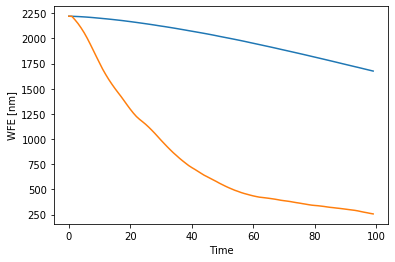

In [34]:

# These are the calibration data used to close the loop
calib_CL    = ao_calib.calib
M2C_CL      = ao_calib.M2C

param['nLoop'] =100
plt.close('all')

# combine telescope with atmosphere
tel+atm

# initialize DM commands
dm.coefs=0
ngs*tel*dm*wfs

plt.ion()
# setup the display
fig         = plt.figure(79)
ax1         = plt.subplot(2,3,1)
im_atm      = ax1.imshow(tel.src.phase)
plt.colorbar(im_atm)
plt.title('Turbulence phase [rad]')

ax2         = plt.subplot(2,3,2)
im_dm       = ax2.imshow(dm.OPD*tel.pupil)
plt.colorbar(im_dm)
plt.title('DM phase [rad]')
tel.computePSF(zeroPaddingFactor=6)

ax4         = plt.subplot(2,3,3)
im_PSF_OL   = ax4.imshow(tel.PSF_trunc)
plt.colorbar(im_PSF_OL)
plt.title('OL PSF')


ax3         = plt.subplot(2,3,5)
im_residual = ax3.imshow(tel.src.phase)
plt.colorbar(im_residual)
plt.title('Residual phase [rad]')

ax5         = plt.subplot(2,3,4)
im_wfs_CL   = ax5.imshow(wfs.cam.frame)
plt.colorbar(im_wfs_CL)
plt.title('Pyramid Frame CL')

ax6         = plt.subplot(2,3,6)
im_PSF      = ax6.imshow(tel.PSF_trunc)
plt.colorbar(im_PSF)
plt.title('CL PSF')

plt.show()

# allocate memory to save data
SR                      = np.zeros(param['nLoop'])
total                   = np.zeros(param['nLoop'])
residual                = np.zeros(param['nLoop'])
wfsSignal               = np.arange(0,wfs.nSignal)*0

# loop parameters
gainCL                  = 0.6
wfs.cam.photonNoise     = True
display                 = False

for i in range(param['nLoop']):
    a=time.time()
    # update phase screens => overwrite tel.OPD and consequently tel.src.phase
    atm.update()
     # save phase variance
    total[i]=np.std(tel.OPD[np.where(tel.pupil>0)])*1e9
     # save turbulent phase
    turbPhase = tel.src.phase
    if display == True:
           # compute the OL PSF and update the display
       tel.computePSF(zeroPaddingFactor=6)
       im_PSF_OL.set_data(np.log(tel.PSF_trunc/tel.PSF_trunc.max()))
       im_PSF_OL.set_clim(vmin=-3,vmax=0)
       
     # propagate to the WFS with the CL commands applied
    tel*dm*wfs
    
     # save the DM OPD shape
    dmOPD=tel.pupil*dm.OPD*2*np.pi/ngs.wavelength
    
    dm.coefs=dm.coefs-gainCL*M2C_CL@calib_CL.M@wfsSignal
     # store the slopes after computing the commands => 2 frames delay
    wfsSignal=wfs.pyramidSignal
    b= time.time()
    print('Elapsed time: ' + str(b-a) +' s')
    # update displays if required
    if display==True:
        
       # Turbulence
       im_atm.set_data(turbPhase)
       im_atm.set_clim(vmin=turbPhase.min(),vmax=turbPhase.max())
       # WFS frame
       C=wfs.cam.frame
       im_wfs_CL.set_data(C)
       im_wfs_CL.set_clim(vmin=C.min(),vmax=C.max())
       # DM OPD
       im_dm.set_data(dmOPD)
       im_dm.set_clim(vmin=dmOPD.min(),vmax=dmOPD.max())
     
       # residual phase
       D=tel.src.phase
       D=D-np.mean(D[tel.pupil])
       im_residual.set_data(D)
       im_residual.set_clim(vmin=D.min(),vmax=D.max()) 
    
       tel.computePSF(zeroPaddingFactor=6)
       im_PSF.set_data(np.log(tel.PSF_trunc/tel.PSF_trunc.max()))
       im_PSF.set_clim(vmin=-4,vmax=0)
       plt.draw()
       plt.show()
       plt.pause(0.001)
    
    
    SR[i]=np.exp(-np.var(tel.src.phase[np.where(tel.pupil==1)]))
    residual[i]=np.std(tel.OPD[np.where(tel.pupil>0)])*1e9
    OPD=tel.OPD[np.where(tel.pupil>0)]

    print('Loop'+str(i)+'/'+str(param['nLoop'])+' Turbulence: '+str(total[i])+' -- Residual:' +str(residual[i])+ '\n')

#%%
plt.figure()
plt.plot(total)
plt.plot(residual)
plt.xlabel('Time')
plt.ylabel('WFE [nm]')

plt.pause(10)
